In [1]:
from read_csv import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data05 = read_csv05('database/data05.csv')
data10 = read_csv10('database/data10.csv')
data20 = read_csv20('database/data20.csv')
print(data05.shape)
print(data10.shape)
print(data20.shape)

mean05 = np.mean(data05, axis=1)
mean10 = np.mean(data10, axis=1)
mean20 = np.mean(data20, axis=1)

data05_all = np.concatenate((data05[0], data05[1], data05[2], data05[3], data05[4]))


(5, 100)
(10, 10)
(20, 12)


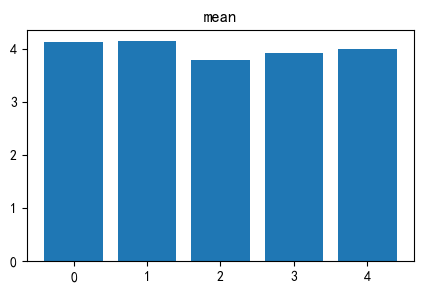

In [3]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (5,3)
plt.title("mean")
x=range(5)
plt.bar(x,mean05)
plt.show()

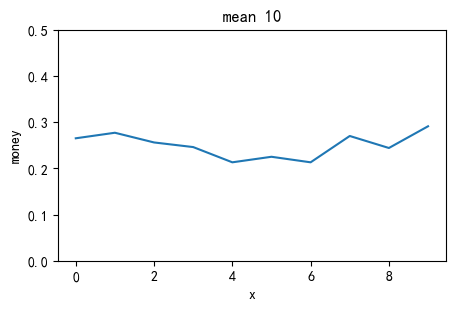

In [4]:
x = range(10)
plt.plot(x, mean10)
plt.title("mean 10")
plt.xlabel("x")
plt.ylabel("money")
plt.ylim(0, 0.5)
plt.show()

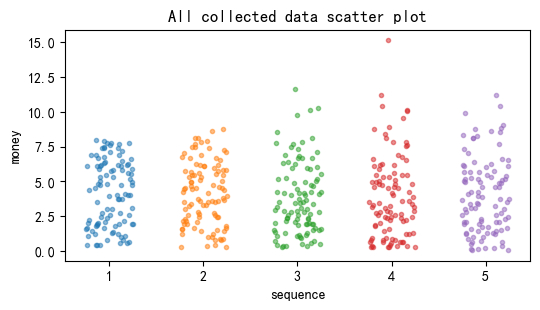

In [5]:
plt.figure(figsize=(6,3))
plt.xlabel("sequence")
plt.ylabel("money")
for i in range(5):
    x = np.random.random(100)
    x = x / 2 + i + 0.75
    plt.scatter(x, data05[i], marker='.', alpha=0.5)
plt.title("All collected data scatter plot")
plt.show()

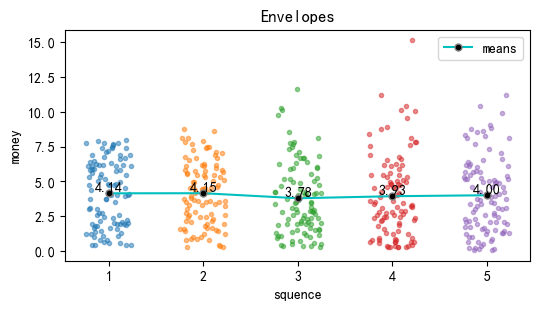

variance for each sqeuence:
[5.50708331 5.02952064 6.52382499 8.67529764 7.18975596]
standard deviation for each sqeuence:
[2.34671756 2.24265928 2.55417795 2.94538582 2.68137203]


In [6]:
plt.figure(figsize=(6,3))
for i in range(5):
    x = np.random.random(100)
    x = x / 2 + i + 0.75
    plt.scatter(x, data05[i], marker='.', alpha=0.5)
x_label = range(1, 6)
plt.plot(x_label,mean05,'c',label='means',markersize=5,markerfacecolor='black',marker='o',markeredgecolor='grey')
plt.xlabel("squence")
plt.ylabel("money")
plt.legend()
plt.title("Envelopes")
for i, j in zip(x_label, mean05):
    plt.text(i, j, '%.2f' % j, ha='center', va='bottom', fontsize=10)
plt.show()
print("variance for each sqeuence:")
print(np.var(data05, axis=1))
print("standard deviation for each sqeuence:")
print(np.std(data05, axis=1))

从直观来看，后抢的人更有可能抢到大红包，但先抢的人平均抢的金额更多。我们从第一个抢红包的人出发试图找出其分布规律。

413.86999999999995


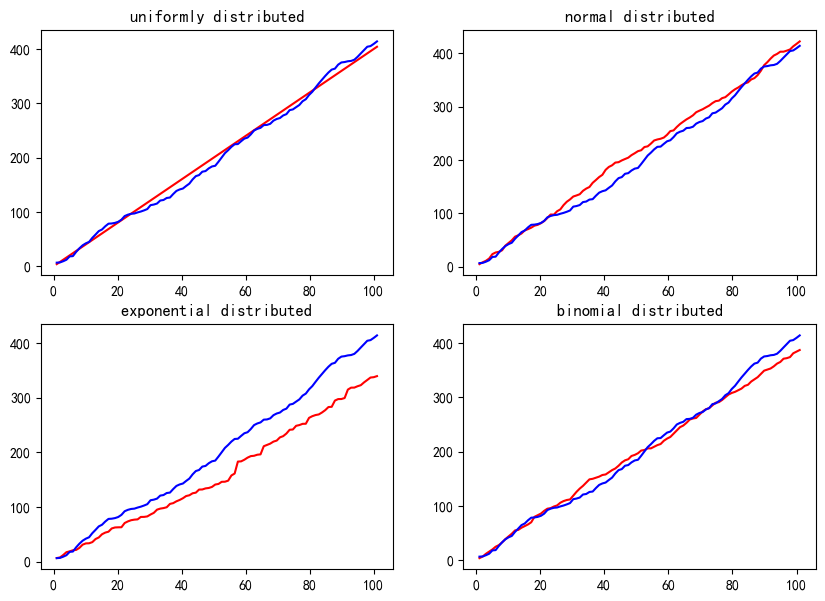

In [7]:
from find_distribution import *


data05_cdf0 = compute_cdf(data05[0])
print(data05_cdf0[99])


x_unif = np.linspace(1, 101, 100)
y_unif = x_unif * 4
# 2.3452 is obtained from sqrt of data05[0] variance
y_norm = np.random.normal(4, 2.3452, 100)
y_norm_cdf = compute_cdf(y_norm)
y_exp = np.random.exponential(4, 100)
y_exp_cdf = compute_cdf(y_exp)
y_binom = np.random.binomial(100, 0.04, 100)
y_binom_cdf = compute_cdf(y_binom)
plt.figure(figsize=(10, 7))
# uniformly distributed
plt.subplot(221)
plt.plot(x_unif, y_unif, 'r', label='y=x*4')
plt.plot(x_unif, data05_cdf0, 'b', label='cdf')
plt.title("uniformly distributed")
# normal distributed
plt.subplot(222)
plt.plot(x_unif, y_norm_cdf, 'r', label='y=x*4')
plt.plot(x_unif, data05_cdf0, 'b', label='cdf')
plt.title("normal distributed")
# exponential distributed
plt.subplot(223)
plt.plot(x_unif, y_exp_cdf, 'r', label='y=x*4')
plt.plot(x_unif, data05_cdf0, 'b', label='cdf')
plt.title("exponential distributed")
# binomial distributed
plt.subplot(224)
plt.plot(x_unif, y_binom_cdf, 'r', label='y=x*4')
plt.plot(x_unif, data05_cdf0, 'b', label='cdf')
plt.title("binomial distributed")
plt.show()

In [8]:
print("Loss of uniform distribution:", compute_loss(data05[0], np.zeros(100) + 4))
print("Loss of normal distribution:", compute_loss(data05[0], y_norm))
print("Loss of exponential distribution:", compute_loss(data05[0], y_exp))
print("Loss of binomial distribution:", compute_loss(data05[0], y_binom))

Loss of uniform distribution: 552.6321
Loss of normal distribution: 1003.7429458778834
Loss of exponential distribution: 1883.5721131892578
Loss of binomial distribution: 898.1320999999998


KL散度也可用于判断

In [9]:
print("KL divergence of uniform distribution:", KL_divergence(data05[0], np.zeros(100) + 4))
print("KL divergence of normal distribution:", KL_divergence(data05[0], y_norm))
print("KL divergence of exponential distribution:", KL_divergence(data05[0], y_exp))
print("KL divergence of binomial distribution:", KL_divergence(data05[0], y_binom))

KL divergence of uniform distribution: 0.18228341699566947
KL divergence of normal distribution: inf
KL divergence of exponential distribution: 0.6698919144341746
KL divergence of binomial distribution: inf


证明上限为2倍剩余平均值：
由于数据集符合均匀分布，所以先验分布选择共轭帕累托分布。
$$p(a) \sim P(b,K) = 
\begin{cases}
    \frac{Kb^K}{a^{K+1}} & \text{if } a \geq b\\
    0                    & otherwise
\end{cases}
$$

其中，b是最小的可能值，a是任何一个大于b的数，K是为正的参数。
这是帕累托分布的一个重要特性，即它的概率密度函数在a=b处开始，并且a>b时递减.这个密度分布函数说a必须大于某个常数b,但不要太大，K用来控制多少是太大。在帕累托分布中，参数K（尺度参数）的值决定了分布的"尾部"的厚度，也就是大于平均值的观测值出现的频率1。K的值越小，尾部越厚，也就是说，大的观测值出现的可能性越大.如果取$K\to 0$ 和 $b\to 0$,则先验变无信息。\
此分布的均值为
$$E(a) = \frac{Kb}{K-1}$$
给定帕累托先验后，和数据集的联合分布为
$$p(D,a) = \frac{Kb^K}{a^{N+K+1}},a \geq max(D)$$
其中D表示数据集，N表示数据集的大小。

In [10]:
print(np.max(data05[0]))

7.96


In [11]:
print(101*7.96/100)

8.0396


均匀分布checked。根据某微信内部代码，0.01~2倍平均值，即0.01~8，利用KS-test

In [12]:
# generate 500 random numbers that are uniformly distributed
unif_data = np.random.uniform(0, 8, 2000)
print(ks_compare(unif_data, data05[0]))

True


验证data[1]~data[4]也同样符合0.01~2倍平均值：

In [13]:
from envelope import *

# the function of generate_envelopes uses algorithm of 0.01 ~ 2*mean
# use it to validate the samples' correctness
envelopes_validation05 = generate_envelopes(20, 5, 1000)
envelopes_validation10 = generate_envelopes(2.5, 10, 1000)
envelopes_validation20 = generate_envelopes(5, 20, 1000)
accuracy05 = 0
accuracy10 = 0
accuracy20 = 0
for i in range(5):
    accuracy05 += ks_compare(envelopes_validation05[i], data05[i])
for i in range(10):
    accuracy10 += ks_compare(envelopes_validation10[i], data10[i])
for i in range(20):
    accuracy20 += ks_compare(envelopes_validation20[i], data20[i])
print("Accuracy when giving 5 people:", accuracy05 * 100 / 5, "%")
print("Accuracy when giving 10 people:", accuracy10 * 100 / 10, "%")
print("Accuracy when giving 20 people:", accuracy20 * 100 / 20, "%")

Accuracy when giving 5 people: 100.0 %
Accuracy when giving 10 people: 90.0 %
Accuracy when giving 20 people: 80.0 %


Due to shortage of money, we can hardly get large samples of envelopes, but the accuracy is still very high even though the data's shape is less than or equal to 10, and gets larger with the size improving, proving that the algorithm we've predicted is correct. The inaccuracy shows that small samples couldn't represent the truth value.

以上可得出微信红包的随机算法。亦可通过数学严格证明。

接下来大量模拟，找出规律。

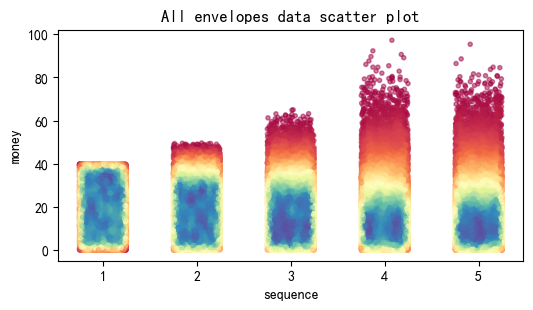

In [14]:
from scipy.stats import gaussian_kde

envelopes = generate_envelopes(100, 5, 20000)
plt.figure(figsize=(6,3))
plt.xlabel("sequence")
plt.ylabel("money")
for i in range(5):
    x = np.random.random(20000)
    x = x / 2 + i + 0.75
    xy = np.vstack([x,envelopes[i]])
    z = gaussian_kde(xy)(xy) 
    plt.scatter(x, envelopes[i], c=z, marker='.', alpha=0.5, cmap='Spectral')
plt.title("All envelopes data scatter plot")
plt.show()

# about 16s

We then give 100 RMB seperately to 10, 20, 50 people:

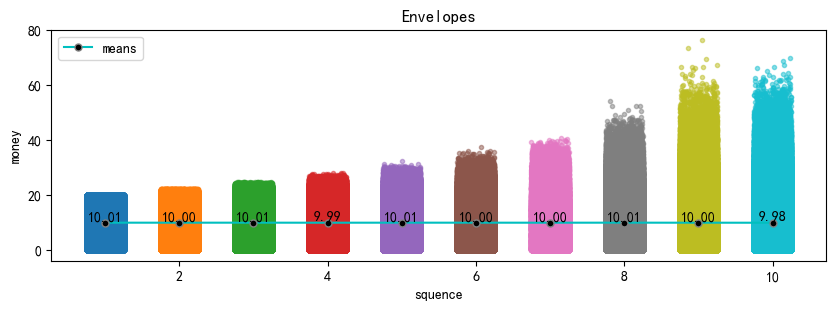

In [15]:
envelopes_10 = generate_envelopes(100, 10, 1000000)
draw_envelope_graph(envelopes_10, 10, 1000000)

# about 1 min

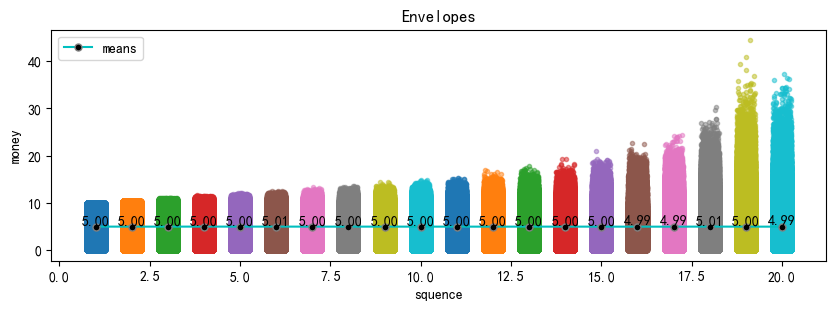

In [16]:
envelopes_20 = generate_envelopes(100, 20, 500000)
draw_envelope_graph(envelopes_20, 20, 500000)

# about 1 min

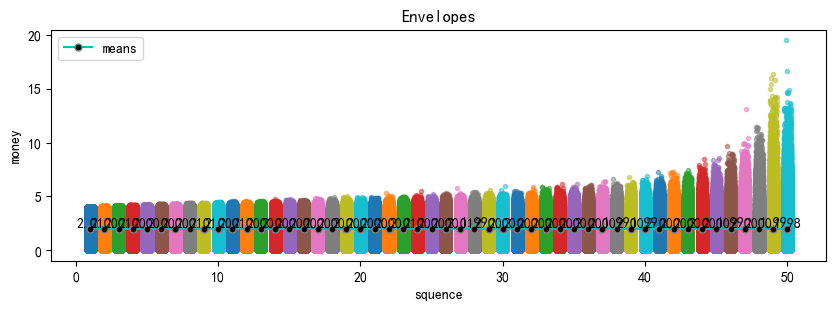

In [17]:
envelopes_50 = generate_envelopes(100, 50, 200000)
draw_envelope_graph(envelopes_50, 50, 200000)

# about 1 min

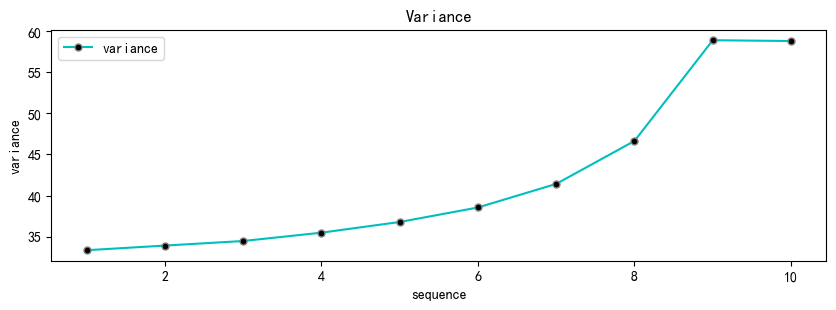

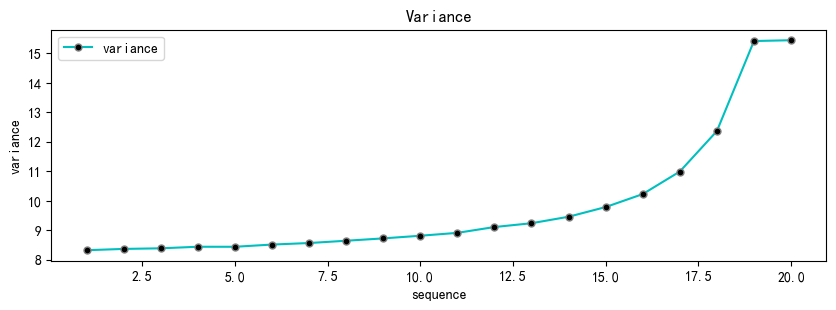

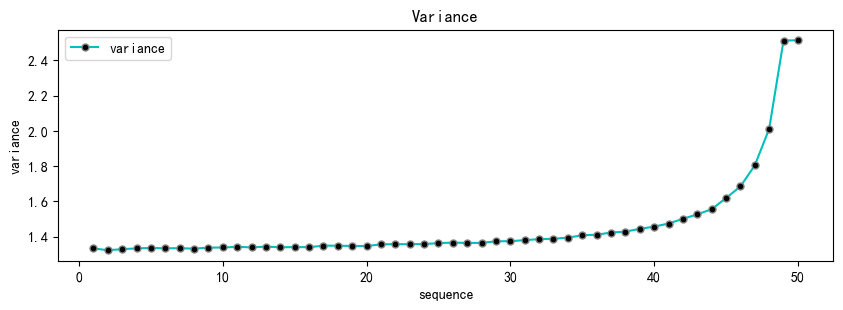

In [18]:
# plot variances
draw_variance(envelopes_10, 10)
draw_variance(envelopes_20, 20)
draw_variance(envelopes_50, 50)